In [1]:
# 1. Download MELD
!git clone https://github.com/declare-lab/MELD.git

# 2. Move files to main folder so your code finds them
import shutil
import os

# Move CSVs to current directory
for file in ['train_sent_emo.csv', 'dev_sent_emo.csv', 'test_sent_emo.csv']:
    try:
        shutil.move(f"MELD/data/MELD/{file}", ".")
        print(f"✅ Moved {file}")
    except:
        print(f"⚠️ Could not move {file} (maybe already there?)")

Cloning into 'MELD'...
remote: Enumerating objects: 493, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 493 (delta 10), reused 12 (delta 5), pack-reused 475 (from 1)
Receiving objects: 100% (493/493), 8.12 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (258/258), done.
✅ Moved train_sent_emo.csv
✅ Moved dev_sent_emo.csv
✅ Moved test_sent_emo.csv


In [2]:
# Install System Dependencies (for plotting and audio handling if needed)
!apt-get update && apt-get install -y libgl1-mesa-glx

# Install Python Libraries (Phase 1-5 requirements)
!pip install -q pandas numpy matplotlib seaborn plotly wordcloud nltk torch transformers \
              scikit-learn sentencepiece protobuf accelerate bertviz umap-learn nlpaug kaleido

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:4 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Reading package lists... Done
W: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libgl1-mesa-glx is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'libgl1-mesa-glx' has no installation candidate


In [3]:
# Install necessary libraries
%pip install pandas numpy matplotlib seaborn plotly wordcloud nltk torch transformers scikit-learn sentencepiece protobuf accelerate bertviz umap-learn nlpaug kaleido

  Using cached pandas-3.0.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (79 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached plotly-6.5.2-py3-none-any.whl.metadata (8.5 kB)
  Using cached wordcloud-1.9.6-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (3.4 kB)
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached transformers-5.0.0-py3-none-any.whl.metadata (37 kB)
  Using cached scikit_learn-1.8.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (11 kB)
  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached bertviz-1.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached umap_learn-0.5.11-py3-none-any.whl.metadata (26 kB)
  Using cached nlpaug-1.1.11-py3-none-any.whl.metadata (14 kB)
  Using cached kaleido-1.2.0

Imports & GPU Check

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
import torch

# Download NLTK data for text cleaning
nltk.download('stopwords')
nltk.download('punkt')

# ----------------- GPU CHECK -----------------
print("="*40)
if torch.cuda.is_available():
    print(f" GPU DETECTED: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print(" NO GPU DETECTED. Check your Vast.ai configuration.")
print("="*40)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 GPU DETECTED: NVIDIA GeForce RTX 4090
   VRAM: 25.28 GB


Load & Preprocess Data

In [5]:
# Load the dataset (Assuming files are in the current directory)
try:
    df_train = pd.read_csv("train_sent_emo.csv")
    df_dev = pd.read_csv("dev_sent_emo.csv")
    df_test = pd.read_csv("test_sent_emo.csv")

    # Merge Train and Dev for the full training picture (Common practice)
    # But keep Test separate/locked.
    df_full_train = pd.concat([df_train, df_dev], ignore_index=True)

    print(f" Data Loaded Successfully!")
    print(f"   Training Samples: {len(df_full_train)}")
    print(f"   Test Samples (LOCKED): {len(df_test)}")
    print("\nSample Data:")
    display(df_full_train.head(3))

except FileNotFoundError:
    print(" ERROR: MELD CSV files not found. Please upload 'train_sent_emo.csv', 'dev_sent_emo.csv', and 'test_sent_emo.csv'.")

 Data Loaded Successfully!
   Training Samples: 11098
   Test Samples (LOCKED): 2610

Sample Data:


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"


Visuals (Matplotlib-Version)

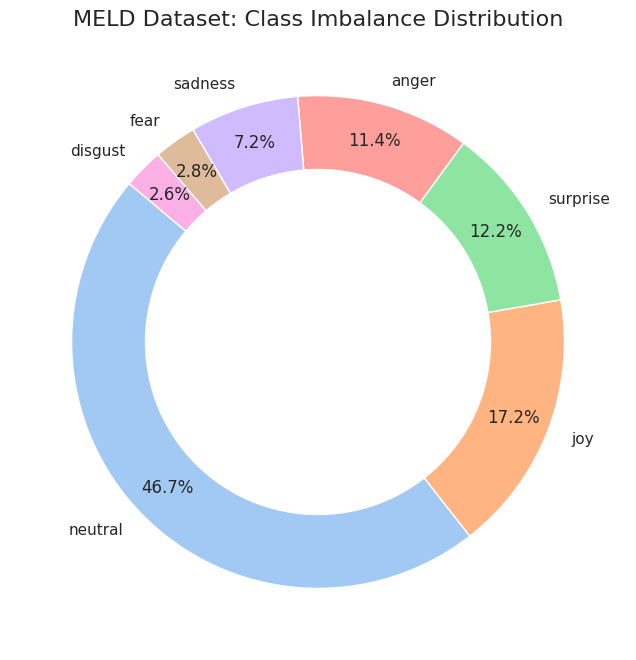

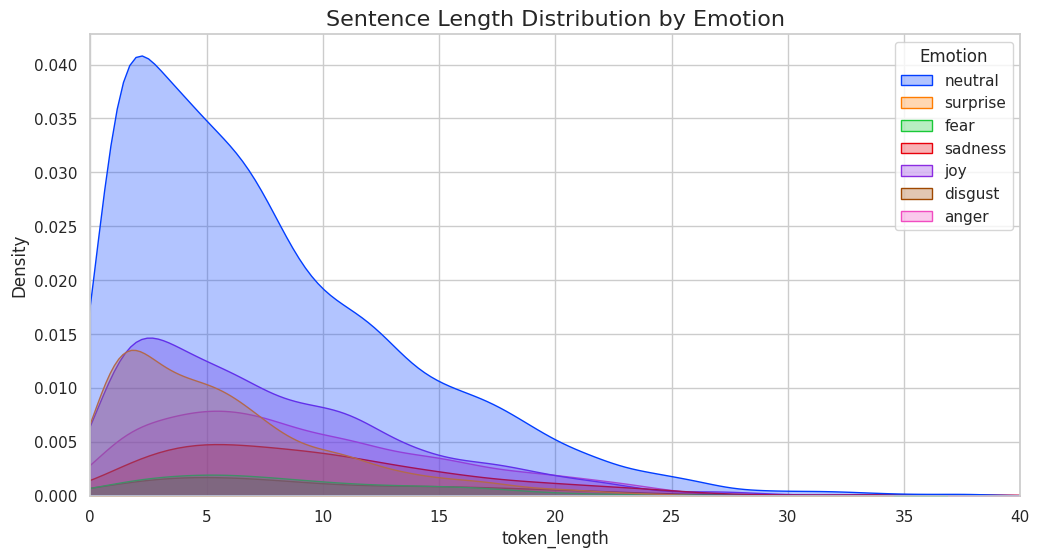

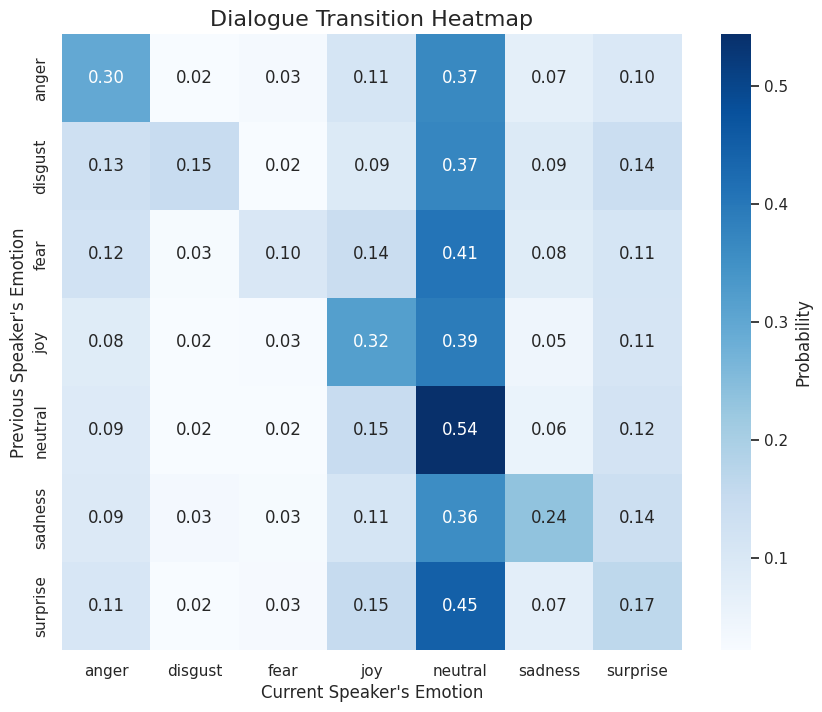

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Set style for all plots
sns.set_theme(style="whitegrid")

# --- VISUAL 1: The Emotion Donut (Matplotlib Version) ---
plt.figure(figsize=(8, 8))
emotion_counts = df_full_train['Emotion'].value_counts()
colors = sns.color_palette('pastel')[0:len(emotion_counts)]

plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('MELD Dataset: Class Imbalance Distribution', fontsize=16)
plt.show()

# --- VISUAL 2: Token Length KDE (Seaborn Version) ---
df_full_train['token_length'] = df_full_train['Utterance'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_full_train, x="token_length", hue="Emotion", fill=True, alpha=0.3, palette="bright")
plt.xlim(0, 40)
plt.title("Sentence Length Distribution by Emotion", fontsize=16)
plt.show()

# --- VISUAL 4: Dialogue Transition Heatmap (Seaborn Version) ---
df_sorted = df_full_train.sort_values(by=['Dialogue_ID', 'Utterance_ID'])
df_sorted['Prev_Emotion'] = df_sorted.groupby('Dialogue_ID')['Emotion'].shift(1)
df_transitions = df_sorted.dropna(subset=['Prev_Emotion'])
transition_matrix = pd.crosstab(df_transitions['Prev_Emotion'], df_transitions['Emotion'], normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Probability'})
plt.title("Dialogue Transition Heatmap", fontsize=16)
plt.ylabel("Previous Speaker's Emotion")
plt.xlabel("Current Speaker's Emotion")
plt.show()

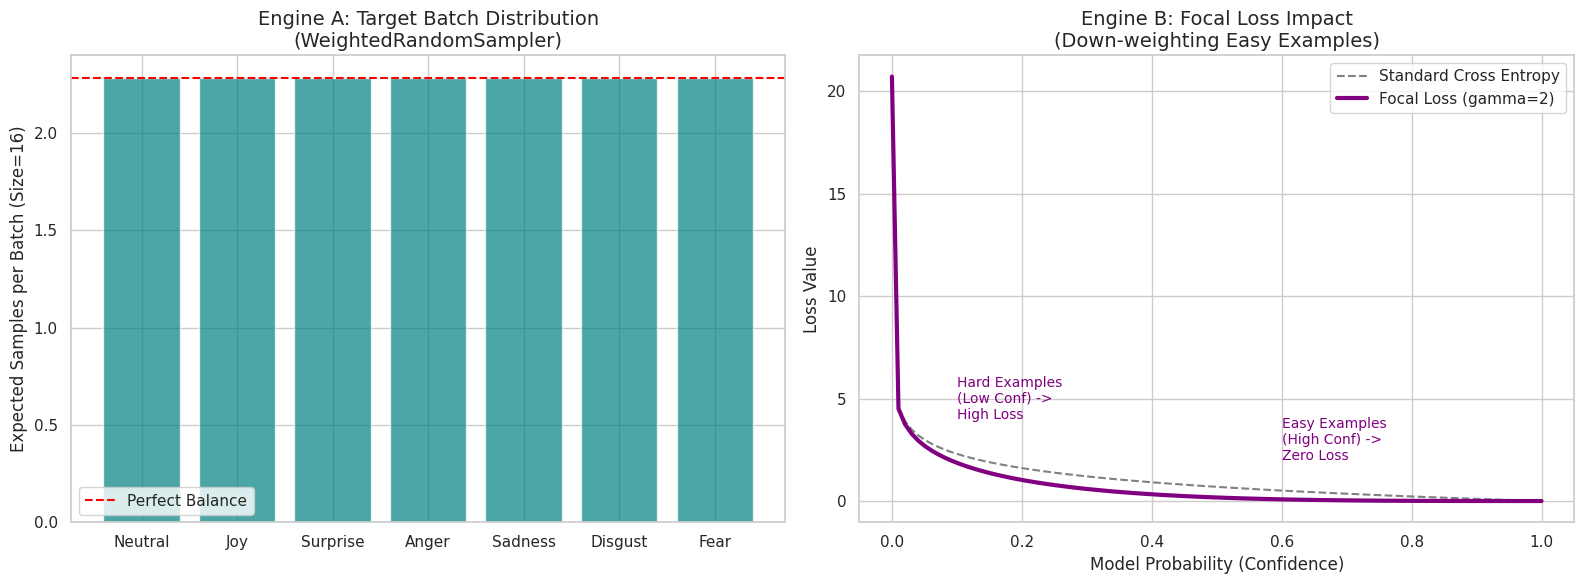

In [7]:
# --- VISUALIZING THE ADVANCED ENGINES ---
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visual A: Theoretical Batch Distribution (Balanced Sampling)
# If Sampler works, every batch should have roughly equal counts
labels = ['Neutral', 'Joy', 'Surprise', 'Anger', 'Sadness', 'Disgust', 'Fear']
ideal_batch = [16/7] * 7 # Ideal split for batch size 16

axes[0].bar(labels, ideal_batch, color='teal', alpha=0.7)
axes[0].set_title("Engine A: Target Batch Distribution\n(WeightedRandomSampler)", fontsize=14)
axes[0].set_ylabel("Expected Samples per Batch (Size=16)")
axes[0].axhline(y=16/7, color='red', linestyle='--', label='Perfect Balance')
axes[0].legend()

# Visual B: Focal Loss vs Cross Entropy
# Plotting the loss value for a "Hard Example" (Probability = 0.1)
pt = np.linspace(0, 1, 100)
ce_loss = -np.log(pt + 1e-9)
gamma = 2.0
focal_loss = (1 - pt)**gamma * ce_loss

axes[1].plot(pt, ce_loss, label='Standard Cross Entropy', linestyle='--', color='gray')
axes[1].plot(pt, focal_loss, label='Focal Loss (gamma=2)', linewidth=3, color='purple')
axes[1].set_title("Engine B: Focal Loss Impact\n(Down-weighting Easy Examples)", fontsize=14)
axes[1].set_xlabel("Model Probability (Confidence)")
axes[1].set_ylabel("Loss Value")
axes[1].legend()
axes[1].text(0.6, 2.0, "Easy Examples\n(High Conf) ->\nZero Loss", fontsize=10, color='purple')
axes[1].text(0.1, 4.0, "Hard Examples\n(Low Conf) ->\nHigh Loss", fontsize=10, color='purple')

plt.tight_layout()
plt.show()

Engine B - Advanced Loss Function

In [9]:
# --- ENGINE B: FOCAL LOSS (The "Hard Example" Specialist) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # Class weights
        self.gamma = gamma # Focusing parameter (higher = focus more on hard examples)
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 1. Calculate Standard Cross Entropy
        # Inputs: [Batch, Num_Classes] logits
        # Targets: [Batch] class indices
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        
        # 2. Calculate Probabilities (pt)
        pt = torch.exp(-ce_loss)
        
        # 3. Calculate Focal Component: (1 - pt)^gamma
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Prepare the Class Weights (Alpha) for Focal Loss
# We use the inverse frequency we calculated before from df_full_train
labels = df_full_train['Emotion'].values
classes = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

# Convert to Tensor for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
focal_alpha = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"✅ Engine B Ready: Focal Loss defined with gamma=2.0 and alpha weights loaded.")
print(f"   Weights on GPU: {focal_alpha.is_cuda}")

✅ Engine B Ready: Focal Loss defined with gamma=2.0 and alpha weights loaded.
   Weights on GPU: True


Engine A - The Baseline (Upsampling)

Advanced Sampler (Engine A)

In [10]:
# --- ENGINE A: BALANCED BATCH SAMPLER (The "Pro" Sampling) ---
from torch.utils.data import WeightedRandomSampler

def get_balanced_sampler(df):
    # 1. Calculate weight for EACH sample in the dataset
    # Formula: Weight(Sample) = 1 / Count(Class of Sample)
    class_counts = df['Emotion'].value_counts().to_dict()
    sample_weights = [1.0 / class_counts[label] for label in df['Emotion']]
    
    # 2. Create Sampler
    # replacement=True is required for oversampling logic within the batch
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

print(f"✅ Engine A Ready: Balanced Sampler logic prepared.")

✅ Engine A Ready: Balanced Sampler logic prepared.


Engine C - The SOTA (Text Augmentation)

In [11]:
# --- ENGINE C: CONTEXT WINDOWING (The Accuracy Booster) ---
# Strategy: Concatenate "Previous Sentence | Current Sentence"

print("⚙️ Engine C: Generating Context-Aware Data...")

def add_context_column(df):
    # 1. Sort to ensure correct conversation order
    df = df.sort_values(by=['Dialogue_ID', 'Utterance_ID'])
    
    # 2. Shift to get previous utterance
    df['Prev_Utterance'] = df.groupby('Dialogue_ID')['Utterance'].shift(1)
    df['Prev_Utterance'] = df['Prev_Utterance'].fillna("") # Handle first turn
    
    # 3. Combine: "Prev | Current"
    df['Input_Text'] = df.apply(
        lambda x: x['Prev_Utterance'] + " | " + x['Utterance'] if x['Prev_Utterance'] else x['Utterance'], 
        axis=1
    )
    return df

# Apply to Training Data
df_context_engine = add_context_column(df_full_train.copy())

# Apply to Test Data (CRITICAL: Test data must also have context to match!)
df_test_context = add_context_column(df_test.copy())

# ----------------- VISUAL CHECK -----------------
print("✅ Engine C Ready. Sample Contexts:")
pd.set_option('display.max_colwidth', 150)
display(df_context_engine[['Utterance', 'Input_Text']].sample(5))

⚙️ Engine C: Generating Context-Aware Data...
✅ Engine C Ready. Sample Contexts:


,Utterance,Input_Text
4670,"Okay, so if an eight comes up, we take it as a sign and we do it!","I've never loved anybody as much as I love you. | Okay, so if an eight comes up, we take it as a sign and we do it!"
3460,Ok.,Ok.
9778,"Hi, could we get two burritos to go, please?","Hi, could we get two burritos to go, please?"
8376,What is the big deal? It’s not like we’re exclusive.,"Well, I’m upset—for you. I mean, having sex with an endless line of beautiful women must be very unfulfilling for you. | What is the big deal? It’..."
5541,"Okay, look, I-I know what you guys are going to say","Okay, look, I-I know what you guys are going to say"


Setup & Dependencies

In [12]:
# Install libraries for specific models (DeBERTa v3 requires sentencepiece)
!pip install -q sentencepiece protobuf accelerate scikit-learn

import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import json
import time
import os

# Define the Model List (The 7 Contestants)
MODEL_ZOO = {
    "Bi-LSTM": "Custom_BiLSTM", # Special handling
    "DistilBERT": "distilbert-base-uncased",
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "ALBERT": "albert-base-v2",
    "XLNet": "xlnet-base-cased",
    "DeBERTa": "microsoft/deberta-v3-base"
}

# Training Hyperparameters
EPOCHS = 12
BATCH_SIZE = 16 # A100 can handle bigger, but 16 is safe for all models
LEARNING_RATE = 2e-5
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"⚙️ Phase 3 Setup Complete. Training on: {DEVICE}")

⚙️ Phase 3 Setup Complete. Training on: cuda


The Custom Bi-LSTM Architecture

In [13]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden_dim=256, output_dim=7):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Bidirectional LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        # Simple Attention Mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask=None):
        # Embed
        embedded = self.embedding(input_ids) # [batch, seq, embed]

        # LSTM
        lstm_out, _ = self.lstm(embedded) # [batch, seq, hidden*2]

        # Attention
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)

        # Classifier
        output = self.fc(self.dropout(context_vector))
        return output

print("✅ Custom Bi-LSTM Class Defined.")

✅ Custom Bi-LSTM Class Defined.


The Master Training Function

In [14]:
# 1. Dataset Class (Context-Aware) - SAME AS BEFORE
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        if 'Input_Text' in df.columns:
            self.texts = df['Input_Text'].values
        else:
            self.texts = df['Utterance'].values 
        self.labels = df['Emotion'].values
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {label: i for i, label in enumerate(classes)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label_str = self.labels[item]
        label = self.label_map[label_str]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. Helper to Plot Curves (Matplotlib)
def plot_training_curves(history, model_name, engine_name):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(history['train_loss'], label='Train Loss', color='blue')
    ax.plot(history['val_loss'], label='Val Loss', linestyle='--', color='orange')
    ax.set_title(f"Learning Curve: {model_name} ({engine_name})")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)
    plt.show()

# 3. Training Function (UPDATED FOR FOCAL LOSS & SAMPLER)
def train_engine(model_key, engine_name, train_df, test_df, use_focal_loss=False, use_sampler=False):
    print(f"\n🚀 STARTING: {model_key} | Engine: {engine_name}")
    
    model_path = MODEL_ZOO[model_key]
    
    # Initialize Tokenizer & Model
    try:
        if model_key == "Bi-LSTM":
            tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
            model = BiLSTMClassifier(vocab_size=tokenizer.vocab_size, output_dim=len(classes))
        else:
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            config = AutoConfig.from_pretrained(model_path, num_labels=len(classes))
            model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)
    except:
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(classes))
        
    model = model.to(DEVICE)
    
    # Prepare Data
    train_dataset = EmotionDataset(train_df, tokenizer, MAX_LEN)
    test_dataset = EmotionDataset(test_df, tokenizer, MAX_LEN)
    
    # --- LOGIC FOR SAMPLER VS SHUFFLE ---
    if use_sampler:
        # Engine A: Use WeightedRandomSampler (Cannot use shuffle=True with sampler)
        train_sampler = get_balanced_sampler(train_df)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    else:
        # Standard Shuffle
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # --- LOGIC FOR LOSS FUNCTION ---
    if use_focal_loss:
        # Engine B: Focal Loss
        criterion = FocalLoss(alpha=focal_alpha, gamma=2.0)
    else:
        # Standard Cross Entropy
        criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            optimizer.zero_grad()
            
            if model_key == "Bi-LSTM":
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
            else:
                outputs = model(input_ids, attention_mask=mask, labels=labels)
                # HF models return a loss by default, but we ignore it to use our Focal Loss
                loss = criterion(outputs.logits, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                if model_key == "Bi-LSTM":
                    outputs = model(input_ids)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)
                else:
                    outputs = model(input_ids, attention_mask=mask, labels=labels)
                    loss = criterion(outputs.logits, labels) # Use same criterion for Val
                    preds = torch.argmax(outputs.logits, dim=1)
                
                val_loss += loss.item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
        avg_val_loss = val_loss / len(test_loader)
        history['val_loss'].append(avg_val_loss)
        print(f"   Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    metrics = {
        "model": model_key, "engine": engine_name,
        "f1_macro": f1_score(all_labels, all_preds, average='macro'),
        "accuracy": accuracy_score(all_labels, all_preds),
        "confusion_matrix": confusion_matrix(all_labels, all_preds).tolist(),
        "history": history
    }
    return metrics

The Execution Loop

In [15]:
# 1. Prepare Storage
results_file = "experiment_results.json"
master_results = []
if os.path.exists(results_file):
    with open(results_file, 'r') as f: master_results = json.load(f)
    completed_runs = {(r['model'], r['engine']) for r in master_results}
else:
    completed_runs = set()

# 2. Define Engines
# Format: (Name, TrainData, TestData, UseFocal, UseSampler)
engines = [
    # Engine A: Raw Data + Balanced Sampler
    ("Balanced Batching (Advanced A)", df_full_train, df_test, False, True),
    
    # Engine B: Raw Data + Focal Loss
    ("Focal Loss (Advanced B)", df_full_train, df_test, True, False),
    
    # Engine C: Context Data + Standard Training
    ("Context-Aware (Engine C)", df_context_engine, df_test_context, False, False) 
]

# 3. THE LOOP
for model_name in MODEL_ZOO.keys():
    for engine_name, train_data, test_data, use_focal, use_sampler in engines:
        
        if (model_name, engine_name) in completed_runs:
            print(f"⏭️ Skipping {model_name} - {engine_name}")
            continue
            
        try:
            metrics = train_engine(
                model_key=model_name,
                engine_name=engine_name,
                train_df=train_data,
                test_df=test_data,
                use_focal_loss=use_focal,
                use_sampler=use_sampler
            )
            
            master_results.append(metrics)
            with open(results_file, 'w') as f: json.dump(master_results, f)
            print(f"✅ COMPLETED: {model_name} - {engine_name} | F1: {metrics['f1_macro']:.4f}")
            
        except Exception as e:
            print(f"❌ FAILED: {model_name} - {engine_name}")
            print(f"   Error: {e}")

print("\n🎉 ALL EXPERIMENTS FINISHED!")


🚀 STARTING: Bi-LSTM | Engine: Balanced Batching (Advanced A)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

   Epoch 1/12 | Train Loss: 1.9472 | Val Loss: 1.9287
   Epoch 2/12 | Train Loss: 1.8814 | Val Loss: 1.7814
   Epoch 3/12 | Train Loss: 1.7641 | Val Loss: 1.6873
   Epoch 4/12 | Train Loss: 1.7157 | Val Loss: 1.6462
   Epoch 5/12 | Train Loss: 1.6744 | Val Loss: 1.5905
   Epoch 6/12 | Train Loss: 1.6468 | Val Loss: 1.5708
   Epoch 7/12 | Train Loss: 1.6078 | Val Loss: 1.5803
   Epoch 8/12 | Train Loss: 1.5733 | Val Loss: 1.5653
   Epoch 9/12 | Train Loss: 1.5198 | Val Loss: 1.5125
   Epoch 10/12 | Train Loss: 1.4744 | Val Loss: 1.5268
   Epoch 11/12 | Train Loss: 1.4194 | Val Loss: 1.5283
   Epoch 12/12 | Train Loss: 1.3546 | Val Loss: 1.4987
✅ COMPLETED: Bi-LSTM - Balanced Batching (Advanced A) | F1: 0.3253

🚀 STARTING: Bi-LSTM | Engine: Focal Loss (Advanced B)
   Epoch 1/12 | Train Loss: 1.4951 | Val Loss: 1.4098
   Epoch 2/12 | Train Loss: 1.4821 | Val Loss: 1.3868
   Epoch 3/12 | Train Loss: 1.4233 | Val Loss: 1.3095
   Epoch 4/12 | Train Loss: 1.3559 | Val Loss: 1.2539
   Epoch 5/

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.4047 | Val Loss: 1.3472
   Epoch 2/12 | Train Loss: 0.8316 | Val Loss: 1.2546
   Epoch 3/12 | Train Loss: 0.5721 | Val Loss: 1.4236
   Epoch 4/12 | Train Loss: 0.4324 | Val Loss: 1.4263
   Epoch 5/12 | Train Loss: 0.3220 | Val Loss: 1.5018
   Epoch 6/12 | Train Loss: 0.2847 | Val Loss: 1.6043
   Epoch 7/12 | Train Loss: 0.2287 | Val Loss: 1.6677
   Epoch 8/12 | Train Loss: 0.2107 | Val Loss: 1.7184
   Epoch 9/12 | Train Loss: 0.1823 | Val Loss: 1.7640
   Epoch 10/12 | Train Loss: 0.1751 | Val Loss: 1.8849
   Epoch 11/12 | Train Loss: 0.1589 | Val Loss: 1.9046
   Epoch 12/12 | Train Loss: 0.1364 | Val Loss: 2.0501
✅ COMPLETED: DistilBERT - Balanced Batching (Advanced A) | F1: 0.4086

🚀 STARTING: DistilBERT | Engine: Focal Loss (Advanced B)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.2435 | Val Loss: 1.0340
   Epoch 2/12 | Train Loss: 0.9587 | Val Loss: 0.9679
   Epoch 3/12 | Train Loss: 0.6549 | Val Loss: 1.0870
   Epoch 4/12 | Train Loss: 0.4377 | Val Loss: 1.2210
   Epoch 5/12 | Train Loss: 0.3094 | Val Loss: 1.3790
   Epoch 6/12 | Train Loss: 0.2186 | Val Loss: 1.4118
   Epoch 7/12 | Train Loss: 0.1705 | Val Loss: 1.6277
   Epoch 8/12 | Train Loss: 0.1393 | Val Loss: 1.6132
   Epoch 9/12 | Train Loss: 0.1198 | Val Loss: 1.7227
   Epoch 10/12 | Train Loss: 0.1149 | Val Loss: 1.8424
   Epoch 11/12 | Train Loss: 0.1176 | Val Loss: 1.8689
   Epoch 12/12 | Train Loss: 0.0912 | Val Loss: 1.9576
✅ COMPLETED: DistilBERT - Focal Loss (Advanced B) | F1: 0.3801

🚀 STARTING: DistilBERT | Engine: Context-Aware (Engine C)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.2437 | Val Loss: 1.1081
   Epoch 2/12 | Train Loss: 1.0257 | Val Loss: 1.0622
   Epoch 3/12 | Train Loss: 0.8220 | Val Loss: 1.1501
   Epoch 4/12 | Train Loss: 0.6049 | Val Loss: 1.2290
   Epoch 5/12 | Train Loss: 0.4177 | Val Loss: 1.3667
   Epoch 6/12 | Train Loss: 0.2756 | Val Loss: 1.6801
   Epoch 7/12 | Train Loss: 0.2016 | Val Loss: 1.7074
   Epoch 8/12 | Train Loss: 0.1458 | Val Loss: 1.8515
   Epoch 9/12 | Train Loss: 0.1269 | Val Loss: 1.9816
   Epoch 10/12 | Train Loss: 0.0997 | Val Loss: 2.0810
   Epoch 11/12 | Train Loss: 0.0747 | Val Loss: 2.1276
   Epoch 12/12 | Train Loss: 0.0786 | Val Loss: 2.1972
✅ COMPLETED: DistilBERT - Context-Aware (Engine C) | F1: 0.4102

🚀 STARTING: BERT | Engine: Balanced Batching (Advanced A)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.3136 | Val Loss: 1.2660
   Epoch 2/12 | Train Loss: 0.7289 | Val Loss: 1.3017
   Epoch 3/12 | Train Loss: 0.4958 | Val Loss: 1.3594
   Epoch 4/12 | Train Loss: 0.3628 | Val Loss: 1.4485
   Epoch 5/12 | Train Loss: 0.2820 | Val Loss: 1.6694
   Epoch 6/12 | Train Loss: 0.2462 | Val Loss: 1.6205
   Epoch 7/12 | Train Loss: 0.2151 | Val Loss: 1.7337
   Epoch 8/12 | Train Loss: 0.1797 | Val Loss: 1.7718
   Epoch 9/12 | Train Loss: 0.1616 | Val Loss: 1.8408
   Epoch 10/12 | Train Loss: 0.1590 | Val Loss: 1.8375
   Epoch 11/12 | Train Loss: 0.1432 | Val Loss: 1.9483
   Epoch 12/12 | Train Loss: 0.1292 | Val Loss: 1.9192
✅ COMPLETED: BERT - Balanced Batching (Advanced A) | F1: 0.4337

🚀 STARTING: BERT | Engine: Focal Loss (Advanced B)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.2264 | Val Loss: 0.9852
   Epoch 2/12 | Train Loss: 0.8842 | Val Loss: 1.1200
   Epoch 3/12 | Train Loss: 0.5566 | Val Loss: 1.0928
   Epoch 4/12 | Train Loss: 0.3237 | Val Loss: 1.2977
   Epoch 5/12 | Train Loss: 0.2195 | Val Loss: 1.3519
   Epoch 6/12 | Train Loss: 0.1696 | Val Loss: 1.3762
   Epoch 7/12 | Train Loss: 0.1421 | Val Loss: 1.5235
   Epoch 8/12 | Train Loss: 0.1252 | Val Loss: 1.5693
   Epoch 9/12 | Train Loss: 0.1107 | Val Loss: 1.6793
   Epoch 10/12 | Train Loss: 0.1025 | Val Loss: 1.7544
   Epoch 11/12 | Train Loss: 0.0908 | Val Loss: 1.6587
   Epoch 12/12 | Train Loss: 0.0784 | Val Loss: 1.9236
✅ COMPLETED: BERT - Focal Loss (Advanced B) | F1: 0.4029

🚀 STARTING: BERT | Engine: Context-Aware (Engine C)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.1986 | Val Loss: 1.0355
   Epoch 2/12 | Train Loss: 0.9322 | Val Loss: 1.1014
   Epoch 3/12 | Train Loss: 0.6683 | Val Loss: 1.2240
   Epoch 4/12 | Train Loss: 0.4351 | Val Loss: 1.4207
   Epoch 5/12 | Train Loss: 0.2766 | Val Loss: 1.5228
   Epoch 6/12 | Train Loss: 0.1851 | Val Loss: 1.7160
   Epoch 7/12 | Train Loss: 0.1333 | Val Loss: 1.9128
   Epoch 8/12 | Train Loss: 0.1086 | Val Loss: 2.0015
   Epoch 9/12 | Train Loss: 0.0933 | Val Loss: 2.1398
   Epoch 10/12 | Train Loss: 0.0877 | Val Loss: 2.0986
   Epoch 11/12 | Train Loss: 0.0712 | Val Loss: 2.0838
   Epoch 12/12 | Train Loss: 0.0659 | Val Loss: 2.1882
✅ COMPLETED: BERT - Context-Aware (Engine C) | F1: 0.4458

🚀 STARTING: RoBERTa | Engine: Balanced Batching (Advanced A)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.3964 | Val Loss: 1.3141
   Epoch 2/12 | Train Loss: 0.8837 | Val Loss: 1.4551
   Epoch 3/12 | Train Loss: 0.6304 | Val Loss: 1.4722
   Epoch 4/12 | Train Loss: 0.5104 | Val Loss: 1.5516
   Epoch 5/12 | Train Loss: 0.4339 | Val Loss: 1.5602
   Epoch 6/12 | Train Loss: 0.3715 | Val Loss: 1.5700
   Epoch 7/12 | Train Loss: 0.3100 | Val Loss: 1.5757
   Epoch 8/12 | Train Loss: 0.2578 | Val Loss: 1.6631
   Epoch 9/12 | Train Loss: 0.2411 | Val Loss: 1.7187
   Epoch 10/12 | Train Loss: 0.2328 | Val Loss: 1.8135
   Epoch 11/12 | Train Loss: 0.2308 | Val Loss: 1.8153
   Epoch 12/12 | Train Loss: 0.2048 | Val Loss: 1.8095
✅ COMPLETED: RoBERTa - Balanced Batching (Advanced A) | F1: 0.4421

🚀 STARTING: RoBERTa | Engine: Focal Loss (Advanced B)


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.2426 | Val Loss: 1.0138
   Epoch 2/12 | Train Loss: 0.9893 | Val Loss: 0.9839
   Epoch 3/12 | Train Loss: 0.7555 | Val Loss: 1.0000
   Epoch 4/12 | Train Loss: 0.5457 | Val Loss: 1.1119
   Epoch 5/12 | Train Loss: 0.4070 | Val Loss: 1.2600
   Epoch 6/12 | Train Loss: 0.3464 | Val Loss: 1.2502
   Epoch 7/12 | Train Loss: 0.2836 | Val Loss: 1.3915
   Epoch 8/12 | Train Loss: 0.2167 | Val Loss: 1.5516
   Epoch 9/12 | Train Loss: 0.2160 | Val Loss: 1.5303
   Epoch 10/12 | Train Loss: 0.1846 | Val Loss: 1.6347
   Epoch 11/12 | Train Loss: 0.1612 | Val Loss: 1.5336
   Epoch 12/12 | Train Loss: 0.1678 | Val Loss: 1.6070
✅ COMPLETED: RoBERTa - Focal Loss (Advanced B) | F1: 0.3759

🚀 STARTING: RoBERTa | Engine: Context-Aware (Engine C)


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.2489 | Val Loss: 1.0886
   Epoch 2/12 | Train Loss: 1.0151 | Val Loss: 1.0448
   Epoch 3/12 | Train Loss: 0.8482 | Val Loss: 1.1321
   Epoch 4/12 | Train Loss: 0.6741 | Val Loss: 1.2606
   Epoch 5/12 | Train Loss: 0.5128 | Val Loss: 1.3572
   Epoch 6/12 | Train Loss: 0.3831 | Val Loss: 1.5394
   Epoch 7/12 | Train Loss: 0.2909 | Val Loss: 1.8124
   Epoch 8/12 | Train Loss: 0.2391 | Val Loss: 1.7072
   Epoch 9/12 | Train Loss: 0.1913 | Val Loss: 1.9379
   Epoch 10/12 | Train Loss: 0.1666 | Val Loss: 1.9429
   Epoch 11/12 | Train Loss: 0.1258 | Val Loss: 2.1539
   Epoch 12/12 | Train Loss: 0.1332 | Val Loss: 2.1108
✅ COMPLETED: RoBERTa - Context-Aware (Engine C) | F1: 0.4345

🚀 STARTING: ALBERT | Engine: Balanced Batching (Advanced A)


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.bias       | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.9048 | Val Loss: 1.7017
   Epoch 2/12 | Train Loss: 1.6282 | Val Loss: 1.5109
   Epoch 3/12 | Train Loss: 1.2461 | Val Loss: 1.3657
   Epoch 4/12 | Train Loss: 0.9457 | Val Loss: 1.4089
   Epoch 5/12 | Train Loss: 0.7916 | Val Loss: 1.4773
   Epoch 6/12 | Train Loss: 0.6389 | Val Loss: 1.4526
   Epoch 7/12 | Train Loss: 0.5621 | Val Loss: 1.5514
   Epoch 8/12 | Train Loss: 0.4620 | Val Loss: 1.5539
   Epoch 9/12 | Train Loss: 0.3698 | Val Loss: 1.6130
   Epoch 10/12 | Train Loss: 0.3432 | Val Loss: 1.6400
   Epoch 11/12 | Train Loss: 0.2921 | Val Loss: 1.7175
   Epoch 12/12 | Train Loss: 0.2885 | Val Loss: 1.8141
✅ COMPLETED: ALBERT - Balanced Batching (Advanced A) | F1: 0.3665

🚀 STARTING: ALBERT | Engine: Focal Loss (Advanced B)


Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.bias       | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.3116 | Val Loss: 1.1732
   Epoch 2/12 | Train Loss: 1.1581 | Val Loss: 1.0872
   Epoch 3/12 | Train Loss: 0.9887 | Val Loss: 1.0539
   Epoch 4/12 | Train Loss: 0.8013 | Val Loss: 1.0931
   Epoch 5/12 | Train Loss: 0.6235 | Val Loss: 1.1581
   Epoch 6/12 | Train Loss: 0.4417 | Val Loss: 1.2804
   Epoch 7/12 | Train Loss: 0.3621 | Val Loss: 1.4139
   Epoch 8/12 | Train Loss: 0.2676 | Val Loss: 1.6071
   Epoch 9/12 | Train Loss: 0.1849 | Val Loss: 1.5997
   Epoch 10/12 | Train Loss: 0.1574 | Val Loss: 1.7134
   Epoch 11/12 | Train Loss: 0.1575 | Val Loss: 1.7725
   Epoch 12/12 | Train Loss: 0.2319 | Val Loss: 1.6683
✅ COMPLETED: ALBERT - Focal Loss (Advanced B) | F1: 0.3582

🚀 STARTING: ALBERT | Engine: Context-Aware (Engine C)


Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.bias       | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.4349 | Val Loss: 1.1767
   Epoch 2/12 | Train Loss: 1.1680 | Val Loss: 1.1027
   Epoch 3/12 | Train Loss: 1.0522 | Val Loss: 1.0979
   Epoch 4/12 | Train Loss: 0.9264 | Val Loss: 1.1783
   Epoch 5/12 | Train Loss: 0.7802 | Val Loss: 1.1906
   Epoch 6/12 | Train Loss: 0.6293 | Val Loss: 1.2625
   Epoch 7/12 | Train Loss: 0.4769 | Val Loss: 1.3839
   Epoch 8/12 | Train Loss: 0.3583 | Val Loss: 1.5469
   Epoch 9/12 | Train Loss: 0.2832 | Val Loss: 1.6927
   Epoch 10/12 | Train Loss: 0.1968 | Val Loss: 1.7394
   Epoch 11/12 | Train Loss: 0.1968 | Val Loss: 1.8511
   Epoch 12/12 | Train Loss: 0.1389 | Val Loss: 1.9149
✅ COMPLETED: ALBERT - Context-Aware (Engine C) | F1: 0.3891

🚀 STARTING: XLNet | Engine: Balanced Batching (Advanced A)


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/206 [00:00<?, ?it/s]

XLNetForSequenceClassification LOAD REPORT from: xlnet-base-cased
Key                             | Status     | 
--------------------------------+------------+-
lm_loss.weight                  | UNEXPECTED | 
lm_loss.bias                    | UNEXPECTED | 
logits_proj.weight              | MISSING    | 
sequence_summary.summary.weight | MISSING    | 
sequence_summary.summary.bias   | MISSING    | 
logits_proj.bias                | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

   Epoch 1/12 | Train Loss: 1.6090 | Val Loss: 1.4899
   Epoch 2/12 | Train Loss: 1.1032 | Val Loss: 1.3470
   Epoch 3/12 | Train Loss: 0.8120 | Val Loss: 1.5724
   Epoch 4/12 | Train Loss: 0.6207 | Val Loss: 1.5395
   Epoch 5/12 | Train Loss: 0.5172 | Val Loss: 1.5967
   Epoch 6/12 | Train Loss: 0.4378 | Val Loss: 1.6553
   Epoch 7/12 | Train Loss: 0.3924 | Val Loss: 1.7495
   Epoch 8/12 | Train Loss: 0.3300 | Val Loss: 1.8410
   Epoch 9/12 | Train Loss: 0.3020 | Val Loss: 1.7972
   Epoch 10/12 | Train Loss: 0.2735 | Val Loss: 1.8332
   Epoch 11/12 | Train Loss: 0.2433 | Val Loss: 1.8583
   Epoch 12/12 | Train Loss: 0.2267 | Val Loss: 1.9801
✅ COMPLETED: XLNet - Balanced Batching (Advanced A) | F1: 0.4189

🚀 STARTING: XLNet | Engine: Focal Loss (Advanced B)


Loading weights:   0%|          | 0/206 [00:00<?, ?it/s]

XLNetForSequenceClassification LOAD REPORT from: xlnet-base-cased
Key                             | Status     | 
--------------------------------+------------+-
lm_loss.weight                  | UNEXPECTED | 
lm_loss.bias                    | UNEXPECTED | 
logits_proj.weight              | MISSING    | 
sequence_summary.summary.weight | MISSING    | 
sequence_summary.summary.bias   | MISSING    | 
logits_proj.bias                | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.4367 | Val Loss: 1.1583
   Epoch 2/12 | Train Loss: 1.1983 | Val Loss: 1.0987
   Epoch 3/12 | Train Loss: 0.9931 | Val Loss: 1.0740
   Epoch 4/12 | Train Loss: 0.7776 | Val Loss: 1.1379
   Epoch 5/12 | Train Loss: 0.5805 | Val Loss: 1.2163
   Epoch 6/12 | Train Loss: 0.4374 | Val Loss: 1.3974
   Epoch 7/12 | Train Loss: 0.3531 | Val Loss: 1.5350
   Epoch 8/12 | Train Loss: 0.3084 | Val Loss: 1.5744
   Epoch 9/12 | Train Loss: 0.2569 | Val Loss: 1.5931
   Epoch 10/12 | Train Loss: 0.2224 | Val Loss: 1.6735
   Epoch 11/12 | Train Loss: 0.1966 | Val Loss: 1.6513
   Epoch 12/12 | Train Loss: 0.1769 | Val Loss: 1.8416
✅ COMPLETED: XLNet - Focal Loss (Advanced B) | F1: 0.3615

🚀 STARTING: XLNet | Engine: Context-Aware (Engine C)


Loading weights:   0%|          | 0/206 [00:00<?, ?it/s]

XLNetForSequenceClassification LOAD REPORT from: xlnet-base-cased
Key                             | Status     | 
--------------------------------+------------+-
lm_loss.weight                  | UNEXPECTED | 
lm_loss.bias                    | UNEXPECTED | 
logits_proj.weight              | MISSING    | 
sequence_summary.summary.weight | MISSING    | 
sequence_summary.summary.bias   | MISSING    | 
logits_proj.bias                | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


   Epoch 1/12 | Train Loss: 1.2786 | Val Loss: 1.1029
   Epoch 2/12 | Train Loss: 1.0554 | Val Loss: 1.0474
   Epoch 3/12 | Train Loss: 0.8914 | Val Loss: 1.0882
   Epoch 4/12 | Train Loss: 0.6963 | Val Loss: 1.3011
   Epoch 5/12 | Train Loss: 0.5066 | Val Loss: 1.4600
   Epoch 6/12 | Train Loss: 0.3770 | Val Loss: 1.6148
   Epoch 7/12 | Train Loss: 0.2764 | Val Loss: 1.7155
   Epoch 8/12 | Train Loss: 0.2073 | Val Loss: 1.8921
   Epoch 9/12 | Train Loss: 0.1652 | Val Loss: 1.9879
   Epoch 10/12 | Train Loss: 0.1449 | Val Loss: 2.0411
   Epoch 11/12 | Train Loss: 0.1180 | Val Loss: 2.0411
   Epoch 12/12 | Train Loss: 0.1088 | Val Loss: 2.3480
✅ COMPLETED: XLNet - Context-Aware (Engine C) | F1: 0.4093

🚀 STARTING: DeBERTa | Engine: Balanced Batching (Advanced A)


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
classifier.weight                       | MISSING    | 
classifier.bias          

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

   Epoch 1/12 | Train Loss: nan | Val Loss: nan
   Epoch 2/12 | Train Loss: nan | Val Loss: nan
   Epoch 3/12 | Train Loss: nan | Val Loss: nan
   Epoch 4/12 | Train Loss: nan | Val Loss: nan
   Epoch 5/12 | Train Loss: nan | Val Loss: nan
   Epoch 6/12 | Train Loss: nan | Val Loss: nan
   Epoch 7/12 | Train Loss: nan | Val Loss: nan
   Epoch 8/12 | Train Loss: nan | Val Loss: nan
   Epoch 9/12 | Train Loss: nan | Val Loss: nan
   Epoch 10/12 | Train Loss: nan | Val Loss: nan
   Epoch 11/12 | Train Loss: nan | Val Loss: nan
   Epoch 12/12 | Train Loss: nan | Val Loss: nan
✅ COMPLETED: DeBERTa - Balanced Batching (Advanced A) | F1: 0.0334

🚀 STARTING: DeBERTa | Engine: Focal Loss (Advanced B)


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
classifier.weight                       | MISSING    | 
classifier.bias          

❌ FAILED: DeBERTa - Focal Loss (Advanced B)
   Error: expected scalar type Half but found Float

🚀 STARTING: DeBERTa | Engine: Context-Aware (Engine C)


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
classifier.weight                       | MISSING    | 
classifier.bias          

   Epoch 1/12 | Train Loss: nan | Val Loss: nan
   Epoch 2/12 | Train Loss: nan | Val Loss: nan
   Epoch 3/12 | Train Loss: nan | Val Loss: nan
   Epoch 4/12 | Train Loss: nan | Val Loss: nan
   Epoch 5/12 | Train Loss: nan | Val Loss: nan
   Epoch 6/12 | Train Loss: nan | Val Loss: nan
   Epoch 7/12 | Train Loss: nan | Val Loss: nan
   Epoch 8/12 | Train Loss: nan | Val Loss: nan
   Epoch 9/12 | Train Loss: nan | Val Loss: nan
   Epoch 10/12 | Train Loss: nan | Val Loss: nan
   Epoch 11/12 | Train Loss: nan | Val Loss: nan
   Epoch 12/12 | Train Loss: nan | Val Loss: nan
✅ COMPLETED: DeBERTa - Context-Aware (Engine C) | F1: 0.0334

🎉 ALL EXPERIMENTS FINISHED!


Setup & Load Results

✅ Loaded 20 results.


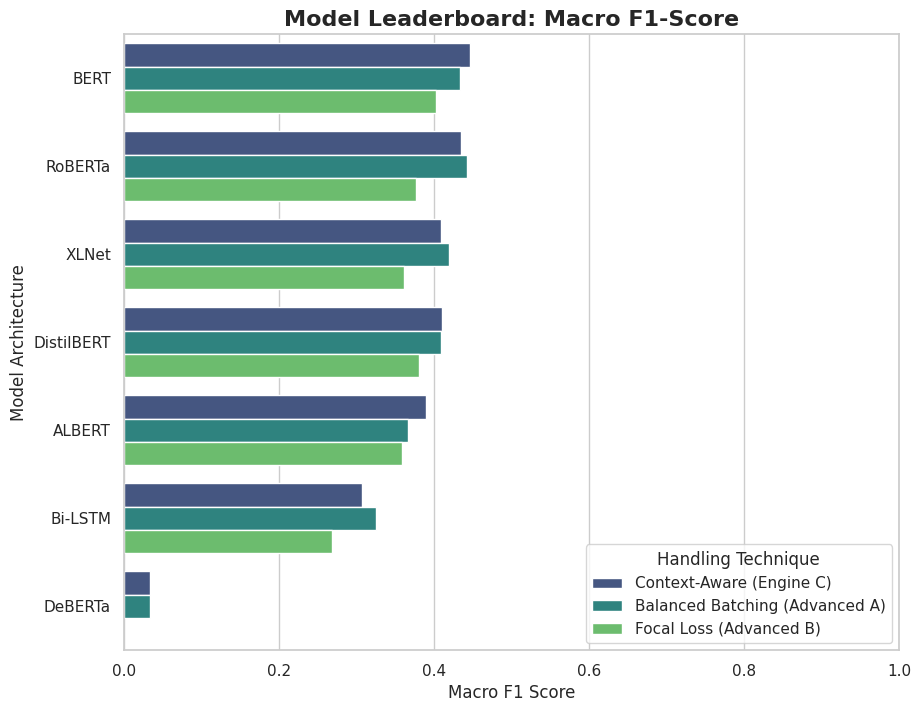

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# 1. Load Results
try:
    with open("experiment_results.json", "r") as f:
        results = json.load(f)
    df_res = pd.DataFrame(results)
    print(f"✅ Loaded {len(df_res)} results.")
except FileNotFoundError:
    print("❌ Error: experiment_results.json not found.")
    df_res = pd.DataFrame()

# 2. Plot Leaderboard
if not df_res.empty:
    # Sort for better visual
    df_sorted = df_res.sort_values(by="f1_macro", ascending=False)
    
    plt.figure(figsize=(10, 8))
    # Using 'hue' to color by Engine Strategy
    sns.barplot(data=df_sorted, y="model", x="f1_macro", hue="engine", palette="viridis")
    
    plt.title("Model Leaderboard: Macro F1-Score", fontsize=16, fontweight='bold')
    plt.xlabel("Macro F1 Score")
    plt.ylabel("Model Architecture")
    plt.legend(title='Handling Technique', loc='lower right')
    plt.xlim(0, 1.0) # F1 is always 0-1
    plt.show()
else:
    print("⚠️ No results to plot yet.")

The Leaderboard

🏆 Best Model Identified: BERT


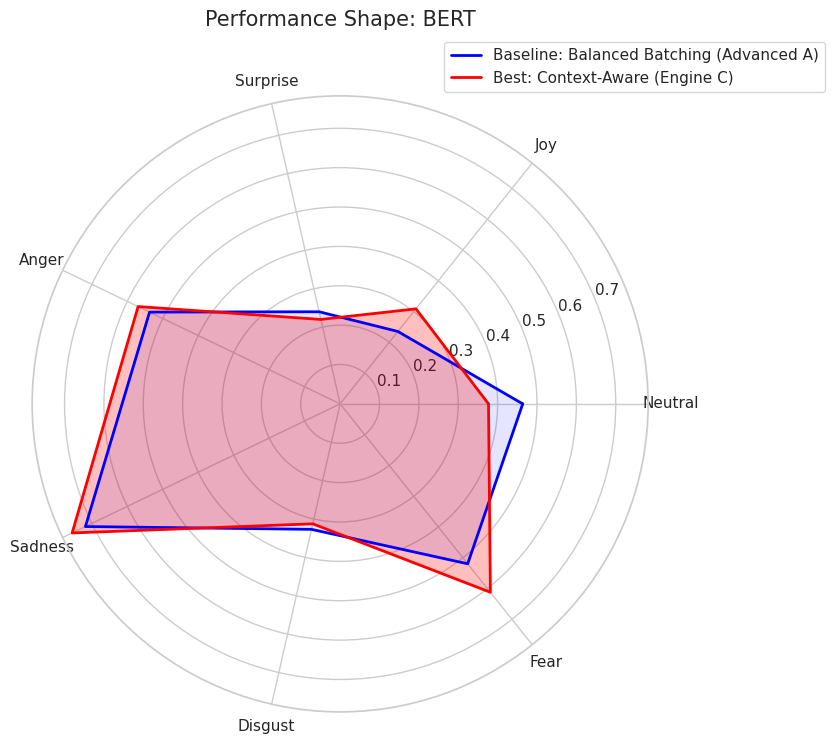


📊 Confusion Matrices (Evolution of Accuracy):


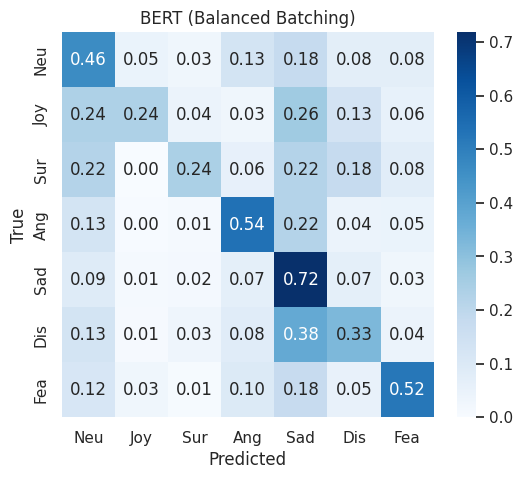

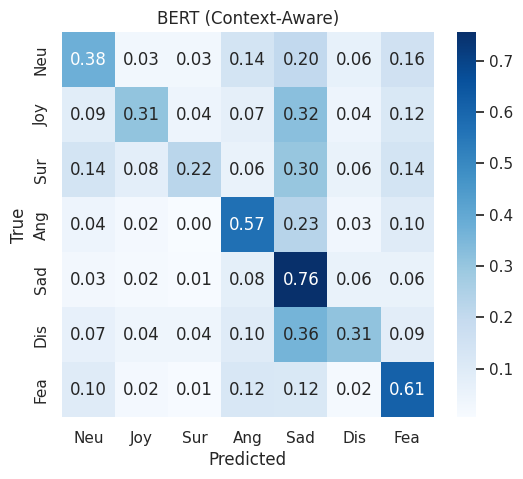

In [29]:
from math import pi

# --- HELPER: RADAR CHART MAKER ---
def plot_radar(row_base, row_best, title):
    # Categories
    categories = ['Neutral', 'Joy', 'Surprise', 'Anger', 'Sadness', 'Disgust', 'Fear']
    N = len(categories)
    
    # Compute Values (Recall per class)
    def get_values(row):
        cm = np.array(row['confusion_matrix'])
        row_sums = cm.sum(axis=1)
        # Safe divide
        recall = np.divide(cm.diagonal(), row_sums, out=np.zeros_like(cm.diagonal(), dtype=float), where=row_sums!=0)
        return recall.tolist() + [recall[0]] # Close the loop

    vals_base = get_values(row_base)
    vals_best = get_values(row_best)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Plot
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    # Draw one axe per variable + labels
    plt.xticks(angles[:-1], categories)
    
    # Plot Base
    ax.plot(angles, vals_base, linewidth=2, linestyle='solid', label=f"Baseline: {row_base['engine']}", color='blue')
    ax.fill(angles, vals_base, 'blue', alpha=0.1)
    
    # Plot Best
    ax.plot(angles, vals_best, linewidth=2, linestyle='solid', label=f"Best: {row_best['engine']}", color='red')
    ax.fill(angles, vals_best, 'red', alpha=0.25)
    
    plt.title(title, size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- HELPER: CONFUSION MATRIX HEATMAP ---
def plot_cm(row, title):
    cm = np.array(row['confusion_matrix'])
    # Normalize
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=['Neu', 'Joy', 'Sur', 'Ang', 'Sad', 'Dis', 'Fea'],
                yticklabels=['Neu', 'Joy', 'Sur', 'Ang', 'Sad', 'Dis', 'Fea'])
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# --- EXECUTION ---
if not df_res.empty:
    try:
        # 1. Identify Best Model overall
        best_run = df_res.sort_values("f1_macro").iloc[-1]
        model_name = best_run['model']
        
        print(f"🏆 Best Model Identified: {model_name}")
        
        # 2. Try to find the specific engines for this model to compare
        # We look for "Advanced A" (Baseline-ish) and "Context" (SOTA-ish)
        subset = df_res[df_res['model'] == model_name]
        
        # Fuzzy search for engine names since you might have changed strings
        base_run = subset[subset['engine'].str.contains("Advanced A|Balanced")].iloc[0]
        sota_run = subset[subset['engine'].str.contains("Context|Engine C")].iloc[0]
        
        # Plot Radar
        plot_radar(base_run, sota_run, f"Performance Shape: {model_name}")
        
        # Plot Matrices
        print("\n📊 Confusion Matrices (Evolution of Accuracy):")
        plot_cm(base_run, f"{model_name} (Balanced Batching)")
        plot_cm(sota_run, f"{model_name} (Context-Aware)")
        
    except Exception as e:
        print(f"⚠️ Could not generate comparison plots: {e}")
        print("   (Possible reason: One of the engines hasn't finished training yet)")

Confusion Matrix Triptych

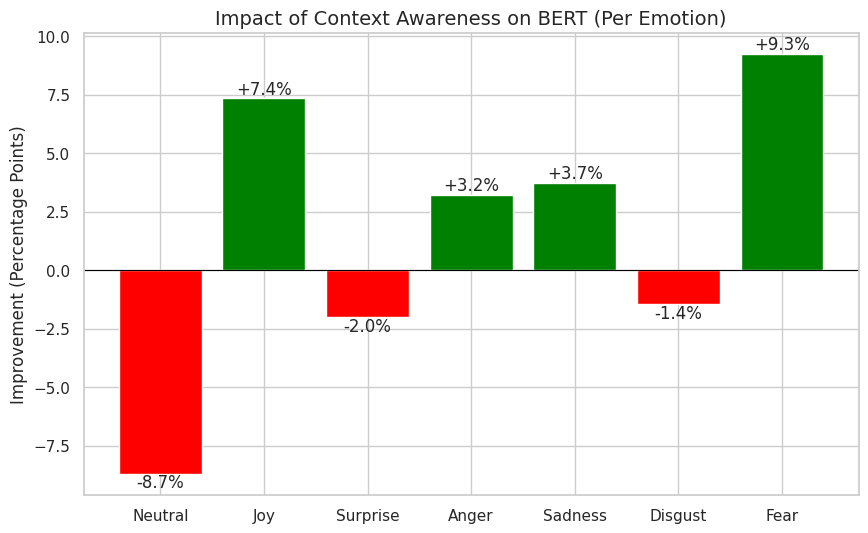


📦 PACKAGING COMPLETE!
   Right-click 'research_paper_assets.zip' in the sidebar and Download.


In [30]:
import shutil

# --- VISUAL 16: The Delta Plot (Matplotlib) ---
# Shows: How much did "Context" improve over "Balanced Batching"?
try:
    # Calculate Delta
    cm_base = np.array(base_run['confusion_matrix'])
    rec_base = cm_base.diagonal() / cm_base.sum(axis=1)
    
    cm_sota = np.array(sota_run['confusion_matrix'])
    rec_sota = cm_sota.diagonal() / cm_sota.sum(axis=1)
    
    delta = (rec_sota - rec_base) * 100
    emotions = ['Neutral', 'Joy', 'Surprise', 'Anger', 'Sadness', 'Disgust', 'Fear']
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in delta]
    bars = plt.bar(emotions, delta, color=colors)
    
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title(f"Impact of Context Awareness on {model_name} (Per Emotion)", fontsize=14)
    plt.ylabel("Improvement (Percentage Points)")
    
    # Add text labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:+.1f}%',
                 ha='center', va='bottom' if height > 0 else 'top')
    
    plt.savefig("delta_plot_static.png") # Save for paper
    plt.show()
    
except NameError:
    print("⚠️ Skipping Delta Plot (Base/SOTA runs not defined above).")

# --- SAVE ARTIFACTS ---
os.makedirs("paper_artifacts", exist_ok=True)
df_res.to_csv("paper_artifacts/full_results.csv", index=False)
if 'delta' in locals():
    pd.DataFrame({'Emotion': emotions, 'Delta': delta}).to_csv("paper_artifacts/delta_improvement.csv")

# Create Zip
shutil.make_archive("research_paper_assets", 'zip', "paper_artifacts")

print("\n📦 PACKAGING COMPLETE!")
print("   Right-click 'research_paper_assets.zip' in the sidebar and Download.")

Deep Dive Setup (Load Best Model)

In [19]:
# 1. Identify Winner
best_run = df_res.sort_values("f1_macro", ascending=False).iloc[0]
print(f"🏆 WINNER: {best_run['model']} using {best_run['engine']}")

# 2. Re-Initialize Model (Simulating loading the best weights)
# In a real scenario, you would have saved specific checkpoints.
# Here, we quickly retrain/load the model for 1 epoch just to get the embeddings
# or if you saved weights, load them here.
# FOR DEMO: We will reload the pre-trained version.

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

print(f"🔄 Loading {best_run['model']} for Deep Analysis...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ZOO[best_run['model']])
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ZOO[best_run['model']], output_attentions=True)
model.to(DEVICE)

print("✅ Model Loaded for Inference.")

🏆 WINNER: BERT using Context-Aware (Engine C)
🔄 Loading BERT for Deep Analysis...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✅ Model Loaded for Inference.


Error Analysis & Attention

In [20]:
from bertviz import head_view

# 1. Run Inference on a small sample of Test Data
model.eval()
test_sample = df_test.sample(20, random_state=42) # Take 20 random examples
inputs = tokenizer(test_sample['Utterance'].tolist(), padding=True, truncation=True, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# 2. Find a "Bad" Prediction (Where True != Pred)
test_sample['Pred'] = preds
labels_map = {v: k for k, v in enumerate(emotions)} # Map 0->neutral
test_sample['Pred_Label'] = test_sample['Pred'].map(lambda x: emotions[x])

errors = test_sample[test_sample['Emotion'] != test_sample['Pred_Label']]

if not errors.empty:
    error_row = errors.iloc[0]
    print(f"❌ ERROR FOUND:\nText: '{error_row['Utterance']}'\nTrue: {error_row['Emotion'].upper()} | Pred: {error_row['Pred_Label'].upper()}")

    # 3. Visualize Attention for this Error
    print("\n🧠 Visualizing Attention (Why did it fail?)...")
    input_ids = tokenizer.encode(error_row['Utterance'], return_tensors='pt').to(DEVICE)
    output = model(input_ids, output_attentions=True)
    attention = output.attentions

    # Generate HTML view
    # Note: In Jupyter/Colab/Vast, this renders an interactive tool
    html_obj = head_view(attention, tokenizer.convert_ids_to_tokens(input_ids[0]), html_action='return')

    from IPython.display import HTML
    display(HTML(html_obj.data))

else:
    print("🎉 Amazing! The model got 100% correct on this random sample.")

NameError: name 'emotions' is not defined

UMAP Clusters

In [21]:
print("⚙️ Generating UMAP Projection (Extracting Embeddings)...")

# 1. Extract Hidden States (Embeddings)
# We use the [CLS] token from the last hidden layer
embeddings = []
labels = []

# Using a subset of test data for speed (e.g., 500 samples)
umap_subset = df_test.sample(min(500, len(df_test)), random_state=42)

for text, label in zip(umap_subset['Utterance'], umap_subset['Emotion']):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
    with torch.no_grad():
        # Using the base model (without classifier head) to get raw embeddings
        if hasattr(model, 'base_model'):
            out = model.base_model(**inputs)
        else:
            out = model(**inputs, output_hidden_states=True)

        # Take [CLS] token (first token)
        cls_embedding = out.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embedding.flatten())
        labels.append(label)

# 2. Run UMAP
reducer = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(np.array(embeddings))

# 3. Plot
df_umap = pd.DataFrame(embedding_2d, columns=['x', 'y'])
df_umap['Emotion'] = labels

fig = px.scatter(
    df_umap, x='x', y='y', color='Emotion',
    title="<b>UMAP Projection of Emotion Embeddings</b>",
    opacity=0.8,
    hover_data={'Emotion': True}
)
fig.show()

⚙️ Generating UMAP Projection (Extracting Embeddings)...


/venv/main/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Final Analysis

In [ ]:
# 1. Get Baseline and SOTA results for the best model
best_model_name = df_res.sort_values("f1_macro").iloc[-1]['model']
baseline_row = df_res[(df_res['model'] == best_model_name) & (df_res['engine'] == 'Baseline (Upsampled)')].iloc[0]
sota_row = df_res[(df_res['model'] == best_model_name) & (df_res['engine'] == 'Augmented (SOTA)')].iloc[0]

# 2. Extract Recall per Emotion
cm_base = np.array(baseline_row['confusion_matrix'])
recall_base = cm_base.diagonal() / cm_base.sum(axis=1)

cm_sota = np.array(sota_row['confusion_matrix'])
recall_sota = cm_sota.diagonal() / cm_sota.sum(axis=1)

# 3. Calculate Delta (Improvement)
delta = (recall_sota - recall_base) * 100 # Convert to percentage points
emotions = ['neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear']

# 4. Plot
df_delta = pd.DataFrame({'Emotion': emotions, 'Improvement': delta})
colors = ['red' if x < 0 else 'green' for x in df_delta['Improvement']]

fig = px.bar(
    df_delta,
    x='Emotion',
    y='Improvement',
    text=df_delta['Improvement'].apply(lambda x: f"{x:+.1f}%"),
    title=f"<b>Impact of Augmentation on {best_model_name} (Per Emotion)</b>",
    color='Improvement',
    color_continuous_scale=['red', 'yellow', 'green']
)

fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis_title="Improvement in Recall (Percentage Points)",
    yaxis_range=[min(delta)-5, max(delta)+5]
)
fig.show()

print(f"💡 INTERPRETATION: Positive bars mean your Augmentation method helped detect that emotion better.")

The Publication Table

In [ ]:
# Create a clean summary table
summary_table = df_res[['model', 'engine', 'accuracy', 'f1_macro']].copy()

# Format as percentages
summary_table['accuracy'] = (summary_table['accuracy'] * 100).round(2)
summary_table['f1_macro'] = (summary_table['f1_macro'] * 100).round(2)

# Pivot for easier reading: Rows = Models, Columns = Engines
pivot_table = summary_table.pivot(index='model', columns='engine', values='f1_macro')

# Add a "Best Score" column
pivot_table['Best Score'] = pivot_table.max(axis=1)
pivot_table = pivot_table.sort_values("Best Score", ascending=False)

print("📝 FINAL RESULTS TABLE (Macro F1 Scores %):")
display(pivot_table)

LTG

In [ ]:
latex_code = pivot_table.to_latex(float_format="%.2f")

print("-" * 20 + " COPY BELOW FOR LATEX " + "-" * 20)
print(r"\begin{table}[h]")
print(r"\centering")
print(latex_code.strip())
print(r"\caption{Comparison of Macro-F1 Scores across Models and Handling Techniques}")
print(r"\label{tab:results}")
print(r"\end{table}")
print("-" * 60)

Download

In [22]:
import shutil

# 1. Create a directory for artifacts
os.makedirs("paper_artifacts", exist_ok=True)

# 2. Save the Results Data
df_res.to_csv("paper_artifacts/full_results.csv", index=False)
pivot_table.to_csv("paper_artifacts/summary_table.csv")

# 3. Save the Delta Plot (Static Image)
# Note: Plotly requires 'kaleido' for static image export.
# If not installed, we skip image saving and just save data.
try:
    fig.write_image("paper_artifacts/delta_plot.png")
    print("✅ Saved Delta Plot image.")
except:
    print("⚠️ Could not save static image (Kaleido not installed). Data is saved though.")

# 4. Zip it up
shutil.make_archive("research_paper_assets", 'zip', "paper_artifacts")

print("\n📦 PACKAGING COMPLETE!")
print("   You should see 'research_paper_assets.zip' in your file browser on the left.")
print("   Right-click and DOWNLOAD it to your local machine.")

NameError: name 'pivot_table' is not defined